In [140]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Attention
from keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import keras.backend as K

In [141]:
current_folder = os.getcwd()
file_path = os.path.join(current_folder,'..' ,'resource', 'RSMC_Best_Track_Data.csv')
df = pd.read_csv(file_path)
df = df.fillna(0)


selected_range_90th = {
    'min_longitude': 106.62499993025,
    'max_longitude': 152.19500002139,
    'min_latitude': 8.51578947368421,
    'max_latitude': 31.64210526315789
}


filtered_data_90th = df[
    (df['Longitude of the center'] >= selected_range_90th['min_longitude']) &
    (df['Longitude of the center'] <= selected_range_90th['max_longitude']) &
    (df['Latitude of the center'] >= selected_range_90th['min_latitude']) &
    (df['Latitude of the center'] <= selected_range_90th['max_latitude'])
]

def get_t_v_t(filtered_data_90th):
    filtered_data_sorted = filtered_data_90th.sort_values(by='Time of analysis').reset_index(drop=True)
    train_size = 0.8
    val_size = 0.1
    test_size = 0.1
    # Group the data by 'International number ID' to maintain the continuity of each typhoon event
    grouped = filtered_data_sorted.groupby('International number ID')

    # Initialize indices for each dataset
    train_indices = []
    val_indices = []
    test_indices = []

    # Initialize counters for the proportions
    train_counter = 0
    val_counter = 0
    test_counter = 0

    total_typhoons = len(grouped)
    train_target = total_typhoons * train_size
    val_target = total_typhoons * val_size
    # Test target is implicit

    # Iterate through each group and assign it to a dataset based on the current proportions
    for name, group in grouped:
        if train_counter < train_target:
            train_indices.extend(group.index)
            train_counter += 1
        elif val_counter < val_target:
            val_indices.extend(group.index)
            val_counter += 1
        else:
            test_indices.extend(group.index)
            test_counter += 1

    # Split the data into train, validation, and test sets
    train_data_continuous = filtered_data_sorted.loc[train_indices]
    val_data_continuous = filtered_data_sorted.loc[val_indices]
    test_data_continuous = filtered_data_sorted.loc[test_indices]

    (train_data_continuous.shape, val_data_continuous.shape, test_data_continuous.shape)

#     X_train = train_data_continuous.drop(["Latitude of the center", "Longitude of the center"], axis=1)
#     X_test = test_data_continuous.drop(["Latitude of the center", "Longitude of the center"], axis=1)
#     y_train = train_data_continuous.loc[:, ["Latitude of the center", "Longitude of the center"]]
#     y_test = test_data_continuous.loc[:, ["Latitude of the center", "Longitude of the center"]]
#     X_val = val_data_continuous.drop(["Latitude of the center", "Longitude of the center"], axis=1)
#     y_val = val_data_continuous.loc[:, ["Latitude of the center", "Longitude of the center"]]

    return train_data_continuous, val_data_continuous, test_data_continuous


def get_train_test_sets(filtered_data):
    filtered_data_sorted = filtered_data.sort_values(by='Time of analysis').reset_index(drop=True)
    train_size = 0.9
    test_size = 0.1

    # Group the data by 'International number ID' to maintain the continuity of each typhoon event
    grouped = filtered_data_sorted.groupby('International number ID')

    # Initialize indices for each dataset
    train_indices = []
    test_indices = []

    # Initialize counters for the proportions
    train_counter = 0
    test_counter = 0

    total_typhoons = len(grouped)
    train_target = total_typhoons * train_size

    # Iterate through each group and assign it to a dataset based on the current proportions
    for name, group in grouped:
        if train_counter < train_target:
            train_indices.extend(group.index)
            train_counter += 1
        else:
            test_indices.extend(group.index)
            test_counter += 1

    # Split the data into train and test sets
    train_data_continuous = filtered_data_sorted.loc[train_indices]
    test_data_continuous = filtered_data_sorted.loc[test_indices]

    return train_data_continuous, test_data_continuous

# Applying the function to the filtered_data_90th dataset
train_data, test_data = get_train_test_sets(filtered_data_90th)


# train_data, val_data, test_data = get_t_v_t(filtered_data_90th)

In [142]:
def get_data_frame(df_in):
    df = df_in
    df = df.fillna(0)
    # ---------------------------

    direction_30_mapping = {'(symmetric circle)': 1, 'Northeast (NE)': 6, 'South (S)': 3,
                            'East (E)': 5, 'Southeast (SE)': 9, 'West (W)': 4, 'North (N)': 2,
                            'Northwest (NW)': 7, 'Southwest (SW)': 8, '0': 0}
    df['Direction of the longest radius of 30kt winds or greater'] = df[
        'Direction of the longest radius of 30kt winds or greater'].map(direction_30_mapping)

    direction_50_mapping = {'(symmetric circle)': 1, 'Northeast (NE)': 6, 'South (S)': 3,
                            'East (E)': 5, 'Southeast (SE)': 9, 'West (W)': 4, 'North (N)': 2,
                            'Northwest (NW)': 7, 'Southwest (SW)': 8,
                            'No direction (Longest radius of 50kt winds is 0)': 10, '0': 0}
    df['Direction of the longest radius of 50kt winds or greater'] = df[
        'Direction of the longest radius of 50kt winds or greater'].map(direction_50_mapping)

    indicator_mapping = {'#': 1, ' ': 0}
    df['Indicator of landfall or passage'] = df['Indicator of landfall or passage'].map(indicator_mapping)
    
    
    

    # ----------------------

    df = df.drop(['Name of the storm', 'Grade','International number ID'], axis=1)
    columns_to_check = [
        'Direction of the longest radius of 50kt winds or greater',
        'The longest radius of 50kt winds or greater',
        'The shortest radius of 50kt winds or greater',
        'Direction of the longest radius of 30kt winds or greater',
        'The longest radius of 30kt winds or greater',
        'The shortest radius of 30kt winds or greater'
    ]
    # df = df.dropna(subset=columns_to_check)


    # -----------------------

    one_hot_encoded = pd.get_dummies(df['Direction of the longest radius of 50kt winds or greater'],
                                     prefix='Direction of the longest radius of 50kt winds or greater', dtype=int)
    df = pd.concat([df, one_hot_encoded], axis=1)

    one_hot_encoded2 = pd.get_dummies(df['Direction of the longest radius of 30kt winds or greater'],
                                      prefix='Direction of the longest radius of 30kt winds or greater', dtype=int)
    df = pd.concat([df, one_hot_encoded2], axis=1)
    df = df.drop(['Direction of the longest radius of 50kt winds or greater',
                  'Direction of the longest radius of 30kt winds or greater'], axis=1)

    # ----------------------

    df['Time of analysis'] = pd.to_datetime(df['Time of analysis'])
    df['Time of analysis'] = df['Time of analysis'].apply(lambda x: x.timestamp())

    # -----------------------
    return df

def min_max_scaler(df):
    
    
    columns_to_normalize = df.columns[:]

    # 实例化 MinMaxScaler
    scaler = MinMaxScaler()

    # 对选择的列进行归一化
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # 打印处理后的新 DataFrame 的信息
    #df.tail()

    return df

def split_data(df):

    split_index = int(0.7 * len(df))

    # 分割DataFrame
    train_set = df.iloc[:split_index, :]
    test_set = df.iloc[split_index:, :]

    train_x = train_set.drop(["Latitude of the center", "Longitude of the center"], axis=1)
    train_y = train_set.loc[:, ["Latitude of the center", "Longitude of the center"]]
    test_x = test_set.drop(["Latitude of the center", "Longitude of the center"], axis=1)
    test_y = test_set.loc[:, ["Latitude of the center", "Longitude of the center"]]
    # 给训练集的标签打上时间序列
    first_column = train_x.iloc[:, 0]
    train_y.insert(0, 'Time of analysis', first_column)
    

    return train_x, train_y, test_x, test_y



    

# df = get_data_frame()
# df_min_max = min_max_scaler(df)
# x_train, y_train, text_x, test_y = split_data(df_min_max)




In [143]:
train_data = get_data_frame(train_data)
train_data = min_max_scaler(train_data)

test_data = get_data_frame(test_data)
test_data = min_max_scaler(test_data)


In [144]:
X_train = train_data.drop(["Latitude of the center", "Longitude of the center"], axis=1)
X_test = test_data.drop(["Latitude of the center", "Longitude of the center"], axis=1)
y_train = train_data.loc[:, ['Time of analysis', "Latitude of the center", "Longitude of the center"]]
y_test = test_data.loc[:, ["Latitude of the center", "Longitude of the center"]]


x_train = X_train
text_x = X_test
test_y = y_test

41571

In [146]:
X_test_whole = x_train.tail(10)
X_test_head = X_test_whole.head(5)

y_test_whole = y_train.tail(10)
y_test_head = y_test_whole.head(5)
y_test_tail = y_test_whole.tail(5)

x_train = x_train.iloc[:-10]


In [155]:
X_val = X_test_whole
y_val = y_test_whole
y_val_reshaped = y_val.values.reshape((y_val.shape[0], y_val.shape[1], 1))

In [147]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41561 entries, 32565 to 27591
Data columns (total 27 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Time of analysis                                               41561 non-null  float64
 1   Central pressure                                               41561 non-null  float64
 2   Maximum sustained wind speed                                   41561 non-null  float64
 3   The longest radius of 50kt winds or greater                    41561 non-null  float64
 4   The shortest radius of 50kt winds or greater                   41561 non-null  float64
 5   The longest radius of 30kt winds or greater                    41561 non-null  float64
 6   The shortest radius of 30kt winds or greater                   41561 non-null  float64
 7   Indicator of landfall or passage                           

In [112]:
@keras.saving.register_keras_serializable()
def haversine_loss(y_true, y_pred):
    lat_true, lon_true = y_true[:, 1], y_true[:, 2]
    lat_pred, lon_pred = y_pred[:, 0], y_pred[:, 1]

    # 将度转换为弧度
    pi = tf.constant(np.pi)
    lat_true, lon_true, lat_pred, lon_pred = [x * (pi / 180) for x in [lat_true, lon_true, lat_pred, lon_pred]]

    dlat = lat_pred - lat_true
    dlon = lon_pred - lon_true

    a = tf.sin(dlat / 2)**2 + tf.cos(lat_true) * tf.cos(lat_pred) * tf.sin(dlon / 2)**2
    c = 2 * tf.asin(tf.sqrt(a))

    # 地球平均半径，单位公里
    R = 6371.0
    return R * c

In [113]:
early_stopper = EarlyStopping(
    monitor='val_loss',  # 监控验证损失
    patience=20,         # 在10个epoch内如果没有改善则停止
    verbose=1,           # 打印早停日志
    mode='min',          # 监控的指标是需要最小化的
    restore_best_weights=True  # 恢复到最佳模型权重
)

In [114]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# 创建回调函数
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [115]:
n_features_x, n_outputs_x = x_train.shape[1], y_train.shape[1]
n_features_y = y_train.shape[1]
y_train_reshaped = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))

In [148]:
print(f"n_features_x: {n_features_x}")
print(f"n_output_x: {n_outputs_x}")

n_features_x: 27
n_output_x: 3


In [156]:
verbose, epochs, batch_size = 1, 100, 160

# Assuming x_train and y_train have shapes: (samples, features) for both x_train and y_train
n_features_x, n_outputs_x = x_train.shape[1], y_train.shape[1]
n_features_y = y_train.shape[1]

# reshape output into [samples, features]
y_train_reshaped = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features_x, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n_outputs_x))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss=haversine_loss, optimizer='adam')

# history = model.fit(x_train.values, y_train_reshaped, 
#                     epochs=epochs, 
#                     batch_size=batch_size, 
#                     verbose=verbose, 
#                     validation_split=0.0005,
#                     callbacks=[early_stopper, lr_scheduler])



history = model.fit(x_train.values, y_train_reshaped, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=verbose, 
                    validation_split=0.0005)

history = model.fit(x_train.values, y_train_reshaped, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=verbose, 
                    validation_data=(X_val.values, y_val_reshaped))

Epoch 1/100
260/260 [==============================] - 6s 16ms/step - loss: 36.6975 - val_loss: 18.5462
Epoch 2/100
260/260 [==============================] - 4s 14ms/step - loss: 34.8273 - val_loss: 19.8424
Epoch 3/100
260/260 [==============================] - 4s 15ms/step - loss: 34.6390 - val_loss: 18.2989
Epoch 4/100
260/260 [==============================] - 4s 15ms/step - loss: 34.4103 - val_loss: 18.2723
Epoch 5/100
260/260 [==============================] - 4s 15ms/step - loss: 34.2338 - val_loss: 18.0122
Epoch 6/100
260/260 [==============================] - 4s 15ms/step - loss: 33.9944 - val_loss: 18.9601
Epoch 7/100
260/260 [==============================] - 4s 15ms/step - loss: 33.8203 - val_loss: 16.9033
Epoch 8/100
260/260 [==============================] - 4s 15ms/step - loss: 33.7036 - val_loss: 20.4768
Epoch 9/100
260/260 [==============================] - 4s 15ms/step - loss: 33.6476 - val_loss: 17.7865
Epoch 10/100
260/260 [==============================] - 4s 15ms/

ValueError: Data cardinality is ambiguous:
  x sizes: 41561
  y sizes: 41571
Make sure all arrays contain the same number of samples.

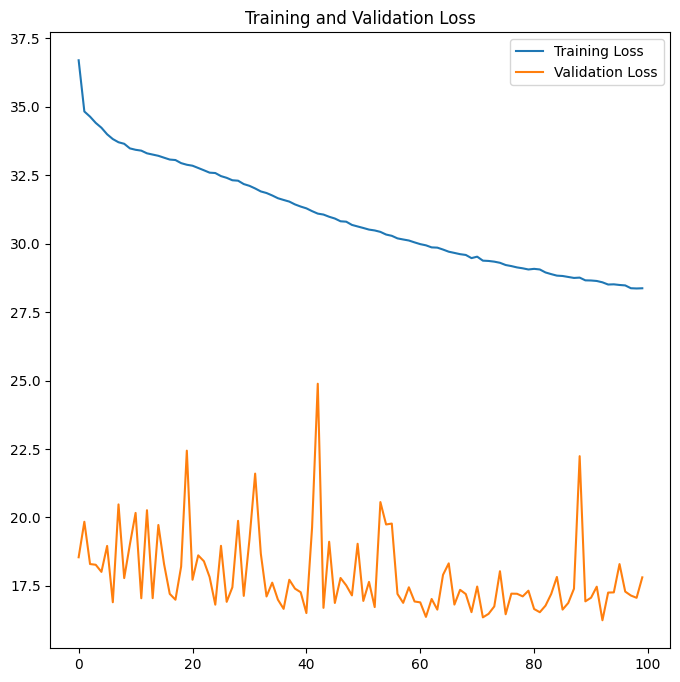

In [157]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))  # Set the range based on the actual number of epochs trained

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

X_test_whole = x_train.tail(10)   
X_test_head = X_test_whole.head(5)   
   
y_test_whole = y_train.tail(10)   
y_test_head = y_test_whole.head(5)   
y_test_tail = y_test_whole.tail(5)
   

1/1 [==============================] - 0s 226ms/step


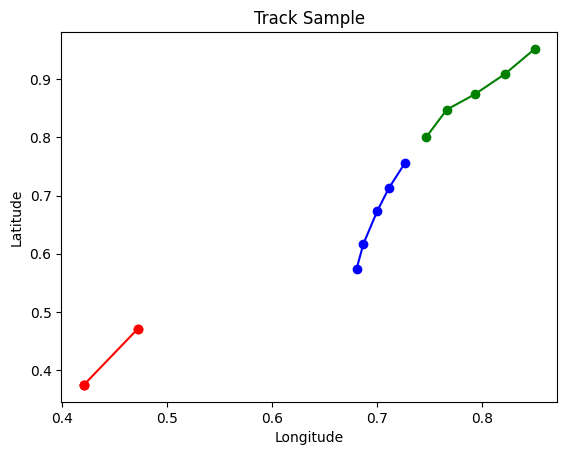

In [158]:
testPredict = model.predict(X_test_head)

#test_head
plt.plot(y_test_head['Longitude of the center'], y_test_head['Latitude of the center'], color='blue', marker='o')
#test_tail
plt.plot(y_test_tail['Longitude of the center'], y_test_tail['Latitude of the center'], color = 'green', marker='o')
#predict
plt.plot(testPredict[:, 2], testPredict[:, 1], label='numpy_array', color='red', marker='o')



# 设置图表标题和轴标签
plt.title('Track Sample')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 显示图表
plt.show()

In [18]:
model.save(r'C:\CODE\tropical_cyclone_prediction\model\CNN-LSTM-EXP10.keras')